In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

# **Reading the file and converting it into numpy array**

In [5]:
import numpy as np
import pandas as pd
import os
from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input/sentiment-images-classifier/Sentiment classifier'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

main_folder = "/kaggle/input/sentiment-images-classifier/6 Emotions for image classification"
classes = os.listdir(main_folder)

data = []
labels = []

target_size = (224, 224)

for class_name in classes:
    class_folder = os.path.join(main_folder, class_name)
    for image_file in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_file)
        # Open image using PIL
        image = Image.open(image_path)
        # Resize image
        image = image.resize(target_size)
        # Convert image to numpy array
        image_array = np.array(image)
        if len(image_array.shape) == 3 and image_array.shape[2] == 3:
            data.append(image_array)
            labels.append(class_name)
        else:
            print("Skipping image:", image_path, "as it does not have 3 channels")

data = np.array(data)
labels = np.array(labels)

print("Shape of data array:", data.shape)
print("Shape of labels array:", labels.shape)

Skipping image: /kaggle/input/sentiment-images-classifier/6 Emotions for image classification/fear/pic92.jpg as it does not have 3 channels
Skipping image: /kaggle/input/sentiment-images-classifier/6 Emotions for image classification/fear/ad963f5cc12f983d8367588d3b156a33--dark-eyes-horror-films.jpg as it does not have 3 channels
Skipping image: /kaggle/input/sentiment-images-classifier/6 Emotions for image classification/fear/panico-540x361.png as it does not have 3 channels
Skipping image: /kaggle/input/sentiment-images-classifier/6 Emotions for image classification/fear/photodune-3175666-fear-m.jpg as it does not have 3 channels
Skipping image: /kaggle/input/sentiment-images-classifier/6 Emotions for image classification/sad/d2d5cb4e2792daba9680d721e737f0ef4.jpg as it does not have 3 channels
Skipping image: /kaggle/input/sentiment-images-classifier/6 Emotions for image classification/sad/4ca85a8078ecffeb4e8258f3635451a2.jpg as it does not have 3 channels
Skipping image: /kaggle/inpu

In [6]:
label_encoder = LabelEncoder()  #converting string label into integer
integer_labels = label_encoder.fit_transform(labels)

In [45]:
x_train,x_test, y_train, y_test = train_test_split(data, integer_labels, test_size=0.2, random_state=42)

In [10]:
print("Training data",x_train.shape)
print("Training Label",y_train.shape)
print("Testing data",x_test.shape)
print("Testing Label",y_test.shape)


Training data (952, 224, 224, 3)
Training Label (952,)
Testing data (238, 224, 224, 3)
Testing Label (238,)


In [46]:
# Data Preprocessing
x_train = x_train / 255.0  # Normalization
x_test = x_test / 255.0

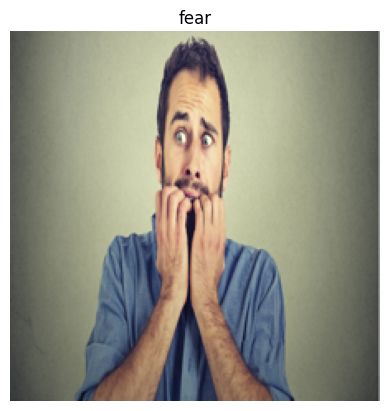

In [9]:
plt.imshow(data[0])
plt.title(labels[0])
plt.axis('off')
plt.show()

# **Transfer Learning VGG19**

In [11]:
inputshape=(224,224,3)
vgg_layers=VGG19(weights='imagenet',include_top=False,input_shape=inputshape)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
vgg_layers.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Fine-tune all the layers
for layer in vgg_layers.layers:
  layer.trainable = True #we are training layers
# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> True
<Conv2D name=block1_conv1, built=True> True
<Conv2D name=block1_conv2, built=True> True
<MaxPooling2D name=block1_pool, built=True> True
<Conv2D name=block2_conv1, built=True> True
<Conv2D name=block2_conv2, built=True> True
<MaxPooling2D name=block2_pool, built=True> True
<Conv2D name=block3_conv1, built=True> True
<Conv2D name=block3_conv2, built=True> True
<Conv2D name=block3_conv3, built=True> True
<Conv2D name=block3_conv4, built=True> True
<MaxPooling2D name=block3_pool, built=True> True
<Conv2D name=block4_conv1, built=True> True
<Conv2D name=block4_conv2, built=True> True
<Conv2D name=block4_conv3, built=True> True
<Conv2D name=block4_conv4, built=True> True
<MaxPooling2D name=block4_pool, built=True> True
<Conv2D name=block5_conv1, built=True> True
<Conv2D name=block5_conv2, built=True> True
<Conv2D name=block5_conv3, built=True> True
<Conv2D name=block5_conv4, built=True> True
<MaxPooling2D name=block5_pool, built=True> True


****

> **Model with 256 Neurons and Dropout Rate 0.3**

In [32]:
model = tf.keras.models.Sequential()
# Add the vgg convolutional base model
model.add(vgg_layers)
# add flatten layer
model.add(tf.keras.layers.Flatten())
# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
# add output layer
model.add(tf.keras.layers.Dense(6, activation='softmax'))
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
# view model layers
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
EPOCHS =100
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True,verbose=1)
history = model.fit(x_train,y_train,batch_size=32,callbacks=[es_callback],validation_split=0.1, epochs=EPOCHS,verbose=1)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 391ms/step - accuracy: 0.1735 - loss: 23.8321 - val_accuracy: 0.2408 - val_loss: 1.7529
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - accuracy: 0.2341 - loss: 155.3097 - val_accuracy: 0.2408 - val_loss: 1.7544
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - accuracy: 0.2206 - loss: 141.9735 - val_accuracy: 0.2094 - val_loss: 1.7644
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


<Axes: >

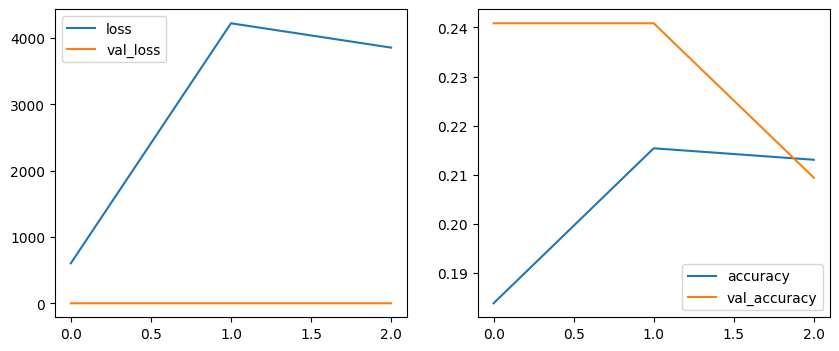

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1])

In [35]:
predictions = model.predict(x_test)
predictions[:5]
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]
class_names=['anger','disgust','fear','happy','pain','sad']
print(classification_report(y_test, prediction_labels,target_names=class_names))
pd.DataFrame(confusion_matrix(y_test, prediction_labels),index=class_names, columns=class_names)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step
              precision    recall  f1-score   support

       anger       0.19      0.81      0.31        80
     disgust       0.36      0.29      0.32        76
        fear       0.17      0.02      0.03        58
       happy       0.24      0.09      0.13        87
        pain       0.67      0.03      0.05        76
         sad       0.47      0.14      0.22        99

    accuracy                           0.24       476
   macro avg       0.35      0.23      0.18       476
weighted avg       0.36      0.24      0.18       476



,anger,disgust,fear,happy,pain,sad
anger,65,8,0,5,0,2
disgust,46,22,1,6,0,1
fear,47,7,1,3,0,0
happy,64,8,1,8,1,5
pain,54,9,0,3,2,8
sad,66,7,3,9,0,14


> **Model with 256 Neurons and Dropout Rate 0.4**

In [11]:
model = tf.keras.models.Sequential()
# Add the vgg convolutional base model
model.add(vgg_layers)
# add flatten layer
model.add(tf.keras.layers.Flatten())
# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.4))
# add output layer
model.add(tf.keras.layers.Dense(6, activation='softmax'))
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
# view model layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
EPOCHS =100
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True,verbose=1)
history = model.fit(x_train,y_train,batch_size=32,callbacks=[es_callback],validation_split=0.1, epochs=EPOCHS,verbose=1)

Epoch 1/100


2024-05-12 09:45:15.499897: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-05-12 09:45:15.499951: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-05-12 09:45:15.499967: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-05-12 09:45:15.499985: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-05-12 09:45:15.499999: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-05-12 09:45:15.500009: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-05-12 09:45:15.500020: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-05-12 09:45:15.500031: E external/local_xla/xla/se

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.1651 - loss: 2.0548

2024-05-12 09:46:00.257398: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50188: 2.79675, expected 2.40555
2024-05-12 09:46:00.257456: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50357: 2.77153, expected 2.38033
2024-05-12 09:46:00.257466: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50399: 2.10715, expected 1.71595
2024-05-12 09:46:00.257496: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 55327: 2.85302, expected 2.46182
2024-05-12 09:46:00.258301: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200704: 4.41732, expected 3.71194
2024-05-12 09:46:00.258334: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200705: 5.86452, expected 5.15914
2024-05-12 09:46:00.258343: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200706: 5.41314, expected 4.70776
2024-05-12 09:46:00.2583

27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.1649 - loss: 2.0497 - val_accuracy: 0.2917 - val_loss: 1.7683
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.2169 - loss: 1.8099 - val_accuracy: 0.3125 - val_loss: 1.6780
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.2874 - loss: 1.6931 - val_accuracy: 0.3021 - val_loss: 1.6325
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.3700 - loss: 1.5972 - val_accuracy: 0.3229 - val_loss: 1.5720
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.4000 - loss: 1.5467 - val_accuracy: 0.4062 - val_loss: 1.5309
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.4523 - loss: 1.4204 - val_accuracy: 0.4167 - val_loss: 1.4695
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.4536 - loss: 1.4179 - val_accuracy: 0.4479 - val_loss: 1.3981
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.5470 - loss: 1.2211 - val_accuracy: 0.4375 -

<Axes: >

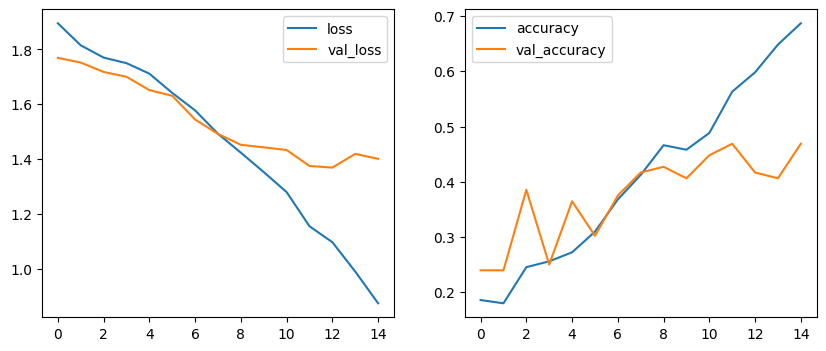

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1])

In [13]:
predictions = model.predict(x_test)
predictions[:5]
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]
class_names=['anger','disgust','fear','happy','pain','sad']
print(classification_report(y_test, prediction_labels,target_names=class_names))
pd.DataFrame(confusion_matrix(y_test, prediction_labels),index=class_names, columns=class_names)

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

2024-05-12 09:48:41.110428: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.83962, expected 3.23333
2024-05-12 09:48:41.110492: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.16738, expected 3.5611
2024-05-12 09:48:41.110509: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.08791, expected 3.48163
2024-05-12 09:48:41.110527: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 4.25991, expected 3.65362
2024-05-12 09:48:41.110540: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 4.65359, expected 4.04731
2024-05-12 09:48:41.110551: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.61877, expected 4.01249
2024-05-12 09:48:41.110562: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.09804, expected 2.49176
2024-05-12 09:48:41.110572: E external/local_xla/xla/

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step 
              precision    recall  f1-score   support

       anger       0.53      0.61      0.57        38
     disgust       0.56      0.69      0.62        39
        fear       0.50      0.35      0.42        31
       happy       0.65      0.23      0.34        48
        pain       0.40      0.47      0.43        34
         sad       0.47      0.67      0.55        48

    accuracy                           0.50       238
   macro avg       0.52      0.50      0.49       238
weighted avg       0.53      0.50      0.49       238



,anger,disgust,fear,happy,pain,sad
anger,23,1,3,0,5,6
disgust,6,27,1,1,0,4
fear,2,6,11,0,3,9
happy,6,5,4,11,10,12
pain,5,5,0,3,16,5
sad,1,4,3,2,6,32


> **Model with 256 Neurons and Dropout Rate 0.6**

In [14]:
model = tf.keras.models.Sequential()
# Add the vgg convolutional base model
model.add(vgg_layers)
# add flatten layer
model.add(tf.keras.layers.Flatten())
# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.6))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.6))
# add output layer
model.add(tf.keras.layers.Dense(6, activation='softmax'))
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
# view model layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
EPOCHS =100
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True,verbose=1)
history = model.fit(x_train,y_train,batch_size=32,callbacks=[es_callback],validation_split=0.1, epochs=EPOCHS,verbose=1)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 575ms/step - accuracy: 0.2039 - loss: 2.0405 - val_accuracy: 0.1979 - val_loss: 1.7844
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - accuracy: 0.1933 - loss: 1.8296 - val_accuracy: 0.1979 - val_loss: 1.7805
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - accuracy: 0.1831 - loss: 1.7831 - val_accuracy: 0.2708 - val_loss: 1.7575
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.2197 - loss: 1.7554 - val_accuracy: 0.3125 - val_loss: 1.7361
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.2442 - loss: 1.7300 - val_accuracy: 0.3333 - val_loss: 1.7103
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - accuracy: 0.2303 - loss: 1.7346 - val_accuracy: 0.3229 - val_loss: 1.6844
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - accuracy: 0.2589 - loss: 1.7165 - val_accuracy: 0.3125 - val_loss: 1.6704
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.2653 - loss: 1.6922 - val_acc

In [17]:
predictions = model.predict(x_test)
predictions[:5]
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]
class_names=['anger','disgust','fear','happy','pain','sad']
print(classification_report(y_test, prediction_labels,target_names=class_names))
pd.DataFrame(confusion_matrix(y_test, prediction_labels),index=class_names, columns=class_names)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step
              precision    recall  f1-score   support

       anger       0.49      0.58      0.53        38
     disgust       0.51      0.69      0.59        39
        fear       0.71      0.32      0.44        31
       happy       0.42      0.42      0.42        48
        pain       0.47      0.24      0.31        34
         sad       0.46      0.58      0.51        48

    accuracy                           0.48       238
   macro avg       0.51      0.47      0.47       238
weighted avg       0.50      0.48      0.47       238



,anger,disgust,fear,happy,pain,sad
anger,22,3,2,4,3,4
disgust,6,27,0,1,0,5
fear,1,6,10,3,0,11
happy,6,7,1,20,4,10
pain,6,6,1,10,8,3
sad,4,4,0,10,2,28


> **Model with 256 Neurons and Dropout Rate 0.5**

In [29]:
model = tf.keras.models.Sequential()
# Add the vgg convolutional base model
model.add(vgg_layers)
# add flatten layer
model.add(tf.keras.layers.Flatten())
# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
# add output layer
model.add(tf.keras.layers.Dense(6, activation='softmax'))
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
# view model layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
EPOCHS =100
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True,verbose=1)
history = model.fit(x_train,y_train,batch_size=32,callbacks=[es_callback],validation_split=0.1, epochs=EPOCHS,verbose=1)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 580ms/step - accuracy: 0.2157 - loss: 1.8405 - val_accuracy: 0.3854 - val_loss: 1.7031
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.2307 - loss: 1.7189 - val_accuracy: 0.4167 - val_loss: 1.6041
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.3497 - loss: 1.5705 - val_accuracy: 0.4375 - val_loss: 1.5124
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - accuracy: 0.4697 - loss: 1.3973 - val_accuracy: 0.4583 - val_loss: 1.3460
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.4911 - loss: 1.2862 - val_accuracy: 0.5000 - val_loss: 1.3492
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.5343 - loss: 1.2513 - val_accuracy: 0.5104 - val_loss: 1.2607
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - accuracy: 0.5613 - loss: 1.1349 - val_accuracy: 0.5729 - val_loss: 1.2388
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.6090 - loss: 1.0290 - val_acc

<Axes: >

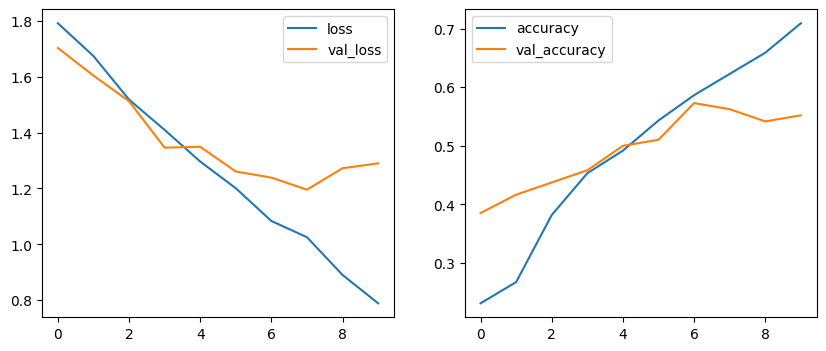

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1])

In [19]:
predictions = model.predict(x_test)
predictions[:5]

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

2024-05-08 17:40:56.474418: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.83962, expected 3.23333
2024-05-08 17:40:56.474486: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.16738, expected 3.5611
2024-05-08 17:40:56.474497: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.08791, expected 3.48163
2024-05-08 17:40:56.474506: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 4.25991, expected 3.65362
2024-05-08 17:40:56.474516: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 4.65359, expected 4.04731
2024-05-08 17:40:56.474525: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.61877, expected 4.01249
2024-05-08 17:40:56.474534: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.09804, expected 2.49176
2024-05-08 17:40:56.474543: E external/local_xla/xla/

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


array([[6.94314659e-01, 3.72813158e-02, 1.39344539e-02, 1.02497749e-02,
        2.22230405e-01, 2.19895020e-02],
       [8.18878636e-02, 3.10739744e-02, 4.56827790e-01, 5.15087992e-02,
        1.27135321e-01, 2.51566321e-01],
       [3.02706420e-01, 5.12137115e-02, 8.99073556e-02, 6.08079098e-02,
        1.57419458e-01, 3.37945133e-01],
       [2.68039003e-04, 4.85474389e-04, 9.91601586e-01, 2.20033122e-04,
        1.33924431e-03, 6.08573295e-03],
       [3.08157764e-02, 1.35262143e-02, 7.86880217e-03, 8.23895097e-01,
        1.55591248e-02, 1.08334966e-01]], dtype=float32)

In [20]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([0, 2, 5, 2, 3])

In [21]:
class_names=['anger','disgust','fear','happy','pain','sad']
print(classification_report(y_test, prediction_labels,target_names=class_names))
pd.DataFrame(confusion_matrix(y_test, prediction_labels),index=class_names, columns=class_names)

              precision    recall  f1-score   support

       anger       0.47      0.71      0.56        38
     disgust       0.68      0.49      0.57        39
        fear       0.59      0.65      0.62        31
       happy       0.53      0.58      0.55        48
        pain       0.64      0.26      0.37        34
         sad       0.53      0.56      0.55        48

    accuracy                           0.55       238
   macro avg       0.57      0.54      0.54       238
weighted avg       0.57      0.55      0.54       238



,anger,disgust,fear,happy,pain,sad
anger,27,0,0,3,1,7
disgust,5,19,4,6,1,4
fear,4,2,20,1,0,4
happy,5,5,3,28,2,5
pain,12,2,2,5,9,4
sad,5,0,5,10,1,27


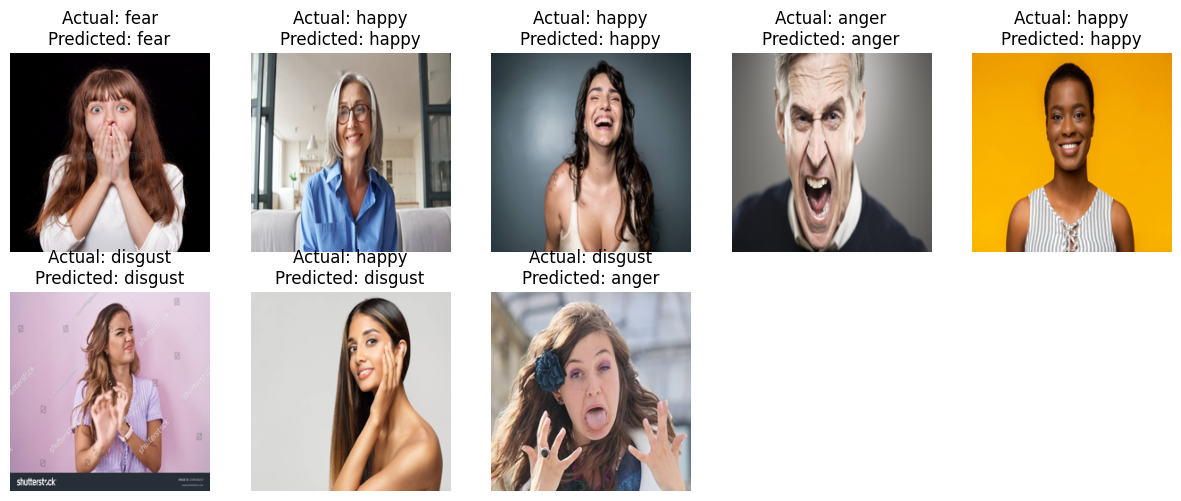

In [24]:
import matplotlib.pyplot as plt

def visualize_images(images, labels, predictions, class_names):
    plt.figure(figsize=(15, 15))
    for i in range(len(images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Actual: {class_names[labels[i]]}\nPredicted: {class_names[predictions[i]]}")
        plt.axis('off')
    plt.show()

visualize_images(x_test[7:15], y_test[7:15], prediction_labels[7:15], class_names)

> **VGG19 with Data Augmentation**

In [18]:
datagen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    rescale=1./255  # Normalize pixel values to [0, 1]
)

In [19]:
augmented_data = []
augmented_labels = []
for X_batch, y_batch in datagen.flow(data, labels, batch_size=32, shuffle=False):
    augmented_data.append(X_batch)
    augmented_labels.append(y_batch)
    if len(augmented_data) *32 >= len(data):
        break
augmented_data = np.concatenate(augmented_data)
augmented_labels = np.concatenate(augmented_labels)

print("Shape of original data array:", data.shape)
print("Shape of augmented data array:", augmented_data.shape)
print("Shape of original labels array:", labels.shape)
print("Shape of augmented labels array:", augmented_labels.shape)

# Concatenate original and augmented data
final_data = np.concatenate((data, augmented_data))
final_labels = np.concatenate((labels, augmented_labels))

print("Shape of final data array:", final_data.shape)
print("Shape of final labels array:", final_labels.shape)

Shape of original data array: (1190, 224, 224, 3)
Shape of augmented data array: (1190, 224, 224, 3)
Shape of original labels array: (1190,)
Shape of augmented labels array: (1190,)
Shape of final data array: (2380, 224, 224, 3)
Shape of final labels array: (2380,)


In [22]:
label_encoder = LabelEncoder()  #converting string label into integer
integer_labels = label_encoder.fit_transform(final_labels)

In [23]:
x_train,x_test, y_train, y_test = train_test_split(final_data, integer_labels, test_size=0.2, random_state=42)

In [24]:
print("Training data",x_train.shape)
print("Training Label",y_train.shape)
print("Testing data",x_test.shape)
print("Testing Label",y_test.shape)

Training data (1904, 224, 224, 3)
Training Label (1904,)
Testing data (476, 224, 224, 3)
Testing Label (476,)


In [25]:
# Data Preprocessing
x_train = x_train / 255.0  # Normalization
x_test = x_test / 255.0

In [26]:
EPOCHS =25
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True,verbose=1)
history = model.fit(x_train,y_train,batch_size=32,callbacks=[es_callback],validation_split=0.1, epochs=EPOCHS,verbose=1)

Epoch 1/25
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.3588 - loss: 1.5825

2024-05-12 09:54:44.618592: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.78784, expected 3.0263
2024-05-12 09:54:44.618660: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.93362, expected 4.17208
2024-05-12 09:54:44.618676: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.6423, expected 3.88076
2024-05-12 09:54:44.618693: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.47141, expected 4.70987
2024-05-12 09:54:44.618706: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.66224, expected 3.90069
2024-05-12 09:54:44.618716: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.17686, expected 3.41531
2024-05-12 09:54:44.618727: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.08184, expected 4.32029
2024-05-12 09:54:44.618737: E external/local_xla/xla/serv

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.3585 - loss: 24.7558

2024-05-12 09:55:08.837457: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 3.62212, expected 2.70127
2024-05-12 09:55:08.837513: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 5.31563, expected 4.39477
2024-05-12 09:55:08.837522: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 5.43093, expected 4.51007
2024-05-12 09:55:08.837532: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100355: 5.35723, expected 4.43638
2024-05-12 09:55:08.837539: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100356: 5.06878, expected 4.14793
2024-05-12 09:55:08.837547: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100357: 5.791, expected 4.87014
2024-05-12 09:55:08.837554: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100358: 5.23388, expected 4.31303
2024-05-12 09:55:08.83

54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 987ms/step - accuracy: 0.3583 - loss: 47.0864 - val_accuracy: 0.3298 - val_loss: 1.5340
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 247ms/step - accuracy: 0.3329 - loss: 1626.2114 - val_accuracy: 0.2461 - val_loss: 1.6594
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 247ms/step - accuracy: 0.2157 - loss: 3703.2542 - val_accuracy: 0.2670 - val_loss: 1.7285
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [27]:
predictions = model.predict(x_test)
predictions[:5]
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]
class_names=['anger','disgust','fear','happy','pain','sad']
print(classification_report(y_test, prediction_labels,target_names=class_names))
pd.DataFrame(confusion_matrix(y_test, prediction_labels),index=class_names, columns=class_names)

14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

2024-05-12 09:55:54.959216: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.05625, expected 3.15318
2024-05-12 09:55:54.959270: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.55379, expected 5.65073
2024-05-12 09:55:54.959285: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.40794, expected 5.50487
2024-05-12 09:55:54.959304: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.4763, expected 4.57323
2024-05-12 09:55:54.959315: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.64422, expected 4.74115
2024-05-12 09:55:54.959326: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.35747, expected 5.45441
2024-05-12 09:55:54.959337: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.0426, expected 5.13953
2024-05-12 09:55:54.959347: E external/local_xla/xla/serv

15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
              precision    recall  f1-score   support

       anger       0.82      0.29      0.43        80
     disgust       0.60      0.37      0.46        76
        fear       0.68      0.29      0.41        58
       happy       0.27      0.93      0.42        87
        pain       0.73      0.21      0.33        76
         sad       0.54      0.28      0.37        99

    accuracy                           0.41       476
   macro avg       0.61      0.40      0.40       476
weighted avg       0.59      0.41      0.40       476



,anger,disgust,fear,happy,pain,sad
anger,23,1,2,45,5,4
disgust,0,28,1,42,1,4
fear,0,3,17,31,0,7
happy,0,3,0,81,0,3
pain,2,5,1,46,16,6
sad,3,7,4,57,0,28


> **Model with 1024 & 512 Neurons and Dropout Rate 0.5**

In [14]:
model = tf.keras.models.Sequential()
# Add the vgg convolutional base model
model.add(vgg_layers)
model.add(GlobalAveragePooling2D())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.2))
# add output layer
model.add(tf.keras.layers.Dense(6, activation='softmax'))
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
# view model layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
EPOCHS =100
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True,verbose=1)
history = model.fit(x_train,y_train,batch_size=32,callbacks=[es_callback],validation_split=0.1, epochs=EPOCHS,verbose=1)

Epoch 1/100


2024-05-12 11:13:19.610337: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-05-12 11:13:19.610410: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-05-12 11:13:19.610420: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-05-12 11:13:19.610428: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-05-12 11:13:19.610436: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-05-12 11:13:19.610444: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-05-12 11:13:19.610451: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-05-12 11:13:19.610459: E external/local_xla/xla/se

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.1839 - loss: 1.8248

2024-05-12 11:14:04.591164: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50188: 2.79675, expected 2.40555
2024-05-12 11:14:04.591225: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50357: 2.77153, expected 2.38033
2024-05-12 11:14:04.591235: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50399: 2.10715, expected 1.71595
2024-05-12 11:14:04.591263: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 55327: 2.85302, expected 2.46182
2024-05-12 11:14:04.592098: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200704: 4.41732, expected 3.71194
2024-05-12 11:14:04.592139: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200705: 5.86452, expected 5.15914
2024-05-12 11:14:04.592148: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200706: 5.41314, expected 4.70776
2024-05-12 11:14:04.5921

27/27 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.1844 - loss: 1.8233 - val_accuracy: 0.2812 - val_loss: 1.7791
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.2179 - loss: 1.7803 - val_accuracy: 0.2812 - val_loss: 1.7420
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.2328 - loss: 1.7250 - val_accuracy: 0.3438 - val_loss: 1.7094
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.2698 - loss: 1.7026 - val_accuracy: 0.2188 - val_loss: 1.7130
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.2866 - loss: 1.6816 - val_accuracy: 0.3750 - val_loss: 1.6304
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.3215 - loss: 1.6324 - val_accuracy: 0.3229 - val_loss: 1.6309
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.3148 - loss: 1.6241 - val_accuracy: 0.3333 - val_loss: 1.6488
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 5.


In [16]:
predictions = model.predict(x_test)
predictions[:5]
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]
class_names=['anger','disgust','fear','happy','pain','sad']
print(classification_report(y_test, prediction_labels,target_names=class_names))
pd.DataFrame(confusion_matrix(y_test, prediction_labels),index=class_names, columns=class_names)

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

2024-05-12 11:15:21.773764: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.83962, expected 3.23333
2024-05-12 11:15:21.773821: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.16738, expected 3.5611
2024-05-12 11:15:21.773831: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.08791, expected 3.48163
2024-05-12 11:15:21.773839: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 4.25991, expected 3.65362
2024-05-12 11:15:21.773847: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 4.65359, expected 4.04731
2024-05-12 11:15:21.773855: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.61877, expected 4.01249
2024-05-12 11:15:21.773862: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.09804, expected 2.49176
2024-05-12 11:15:21.773870: E external/local_xla/xla/

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step 
              precision    recall  f1-score   support

       anger       0.25      0.45      0.32        38
     disgust       0.66      0.54      0.59        39
        fear       0.00      0.00      0.00        31
       happy       0.22      0.33      0.26        48
        pain       0.00      0.00      0.00        34
         sad       0.35      0.46      0.40        48

    accuracy                           0.32       238
   macro avg       0.24      0.30      0.26       238
weighted avg       0.26      0.32      0.28       238



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,anger,disgust,fear,happy,pain,sad
anger,17,2,0,12,0,7
disgust,6,21,0,5,0,7
fear,7,2,0,11,0,11
happy,18,2,0,16,0,12
pain,14,4,0,12,0,4
sad,7,1,0,18,0,22


# **INCEPTION V3**

In [48]:
num_classes = len(classes)
y_train_encoded = to_categorical(y_train, num_classes=num_classes) #Inception V3 expects categorical labels.
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

In [49]:
# Data preprocessing
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Create InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [19]:
base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

> **Inception with 1024 & 512 neurons and dropout rate 0.2**

In [20]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation="softmax"))
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True,verbose=1)
history = model.fit(x_train, y_train_encoded, batch_size=32, epochs=25,callbacks=[es_callback],validation_data=(x_test, y_test_encoded))

Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.2888 - loss: 1.6943 - val_accuracy: 0.1639 - val_loss: 2.1131
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.8036 - loss: 0.7186 - val_accuracy: 0.1975 - val_loss: 1.9336
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9509 - loss: 0.2377 - val_accuracy: 0.2059 - val_loss: 2.0634
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.9831 - loss: 0.0874 - val_accuracy: 0.1471 - val_loss: 2.4776
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


In [22]:
predictions = model.predict(x_test)
predictions[:5]
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]
class_names=['anger','disgust','fear','happy','pain','sad']
print(classification_report(y_test, prediction_labels,target_names=class_names))
pd.DataFrame(confusion_matrix(y_test, prediction_labels),index=class_names, columns=class_names)

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 848ms/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        38
     disgust       0.21      0.95      0.35        39
        fear       0.13      0.19      0.16        31
       happy       0.00      0.00      0.00        48
        pain       0.00      0.00      0.00        34
         sad       0.20      0.08      0.12        48

    accuracy                           0.20       238
   macro avg       0.09      0.20      0.10       238
weighted avg       0.09      0.20      0.10       238



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,anger,disgust,fear,happy,pain,sad
anger,0,23,12,0,0,3
disgust,0,37,1,0,0,1
fear,0,22,6,0,0,3
happy,0,30,10,0,0,8
pain,0,22,11,0,0,1
sad,0,39,5,0,0,4


> **Inception with 256 neurons and dropout rate 0.5**

In [39]:
model = tf.keras.models.Sequential()
# Add the vgg convolutional base model
model.add(base_model)
# add flatten layer
model.add(tf.keras.layers.Flatten())
# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
# add output layer
model.add(tf.keras.layers.Dense(6, activation='softmax'))
# compile model
model.compile(optimizer=RMSprop(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True,verbose=1)
history = model.fit(x_train, y_train_encoded, batch_size=32, epochs=20,validation_data=(x_test, y_test_encoded))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.2123 - loss: 2.1770 - val_accuracy: 0.1639 - val_loss: 1.8057
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.2706 - loss: 1.7570 - val_accuracy: 0.2059 - val_loss: 1.7798
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.3701 - loss: 1.5924 - val_accuracy: 0.1681 - val_loss: 1.8002
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.4184 - loss: 1.4776 - val_accuracy: 0.1765 - val_loss: 1.7997
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.4603 - loss: 1.3455 - val_accuracy: 0.1933 - val_loss: 1.7992
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.5426 - loss: 1.1772 - val_accuracy: 0.2101 - val_loss: 1.7832
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.6342 - loss: 1.0114 - val_accuracy: 0.2017 - val_loss: 1.8142
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.6725 - loss: 0.8706 - val_accuracy: 0.2

In [41]:
predictions = model.predict(x_test)
predictions[:5]
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]
class_names=['anger','disgust','fear','happy','pain','sad']
print(classification_report(y_test, prediction_labels,target_names=class_names))
pd.DataFrame(confusion_matrix(y_test, prediction_labels),index=class_names, columns=class_names)

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 763ms/step
              precision    recall  f1-score   support

       anger       0.63      0.50      0.56        38
     disgust       0.62      0.74      0.67        39
        fear       0.56      0.61      0.58        31
       happy       0.62      0.58      0.60        48
        pain       0.50      0.62      0.55        34
         sad       0.68      0.56      0.61        48

    accuracy                           0.60       238
   macro avg       0.60      0.60      0.60       238
weighted avg       0.61      0.60      0.60       238



,anger,disgust,fear,happy,pain,sad
anger,19,3,2,4,7,3
disgust,0,29,1,4,3,2
fear,2,4,19,3,3,0
happy,4,5,4,28,4,3
pain,1,4,1,2,21,5
sad,4,2,7,4,4,27


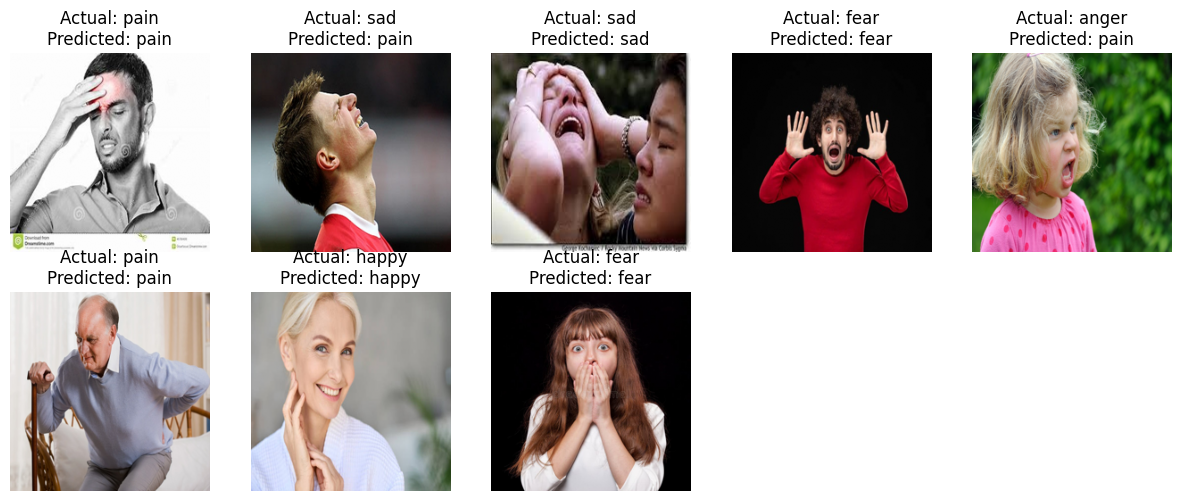

In [47]:
def visualize_images(images, labels, predictions, class_names):
    plt.figure(figsize=(15, 15))
    for i in range(0,8):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Actual: {class_names[labels[i]]}\nPredicted: {class_names[predictions[i]]}")
        plt.axis('off')
    plt.show()

visualize_images(x_test[0:8], y_test[0:8], prediction_labels[0:8], class_names)

In [50]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True,verbose=1)
history = model.fit(x_train, y_train_encoded, batch_size=32, epochs=50,validation_data=(x_test, y_test_encoded))

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.9744 - loss: 0.0966 - val_accuracy: 0.6345 - val_loss: 1.5027
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9804 - loss: 0.0729 - val_accuracy: 0.6176 - val_loss: 1.6274
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.9772 - loss: 0.0732 - val_accuracy: 0.6134 - val_loss: 1.5933
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9818 - loss: 0.0533 - val_accuracy: 0.6050 - val_loss: 1.6451
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9749 - loss: 0.0810 - val_accuracy: 0.6092 - val_loss: 1.6703
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9866 - loss: 0.0456 - val_accuracy: 0.6008 - val_loss: 1.7287
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9844 - loss: 0.0555 - val_accuracy: 0.6050 - val_loss: 1.7821
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9836 - loss: 0.0427 - val_accuracy: 0.

In [51]:
predictions = model.predict(x_test)
predictions[:5]
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]
class_names=['anger','disgust','fear','happy','pain','sad']
print(classification_report(y_test, prediction_labels,target_names=class_names))
pd.DataFrame(confusion_matrix(y_test, prediction_labels),index=class_names, columns=class_names)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
              precision    recall  f1-score   support

       anger       0.58      0.68      0.63        38
     disgust       0.61      0.79      0.69        39
        fear       0.63      0.61      0.62        31
       happy       0.69      0.60      0.64        48
        pain       0.63      0.79      0.70        34
         sad       0.59      0.33      0.43        48

    accuracy                           0.62       238
   macro avg       0.62      0.64      0.62       238
weighted avg       0.62      0.62      0.61       238



,anger,disgust,fear,happy,pain,sad
anger,26,4,1,2,3,2
disgust,3,31,0,2,2,1
fear,3,5,19,0,1,3
happy,4,5,2,29,4,4
pain,0,3,1,2,27,1
sad,9,3,7,7,6,16
